<a href="https://colab.research.google.com/github/JorgeTonatiuh/aprendizaje_profundo_tarea_2/blob/main/reconocimiento_de_acciones_humanas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de acciones humanas

Comparar arquitecturas RNN y CNN para reconocimiento de acciones humanas en el conjunto UCF11. La solución debe cumplir con los siguientes puntos.

- Usar las características convolucionales vistas en clase
- Implementar una arquitectura RNN bidireccional con una capa GRU.
- Implementar una arquitectura CNN con una capa Conv1d.
- Modificar el tamaño de las capas para que ambos modelos tengan un número similar de parámetros.
- Discutir el comportamiento durante el entrenamiento y resultados finales en ambos conjuntos.


# 1 Preparación

In [2]:
# Colab
# https://github.com/TylerYep/torchinfo
!pip install torchinfo
# https://zarr.readthedocs.io/en/stable/
!pip install zarr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 4.8 MB/s 
     |████████████████████████████████| 6.6 MB 60.2 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=5092aec58dc1f97202d2f9685e522f3509bdfcceac28db014e8fa3361c3a032e
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built asciitree


## 1.1 Bibliotecas

In [3]:
# sistema de archivos
import os
# funciones aleatorias
import random
# descomprimir
import tarfile
# sistema de archivos
from os.path import join
# tomar n elementos de una secuencia
from itertools import islice as take
# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
# almacenamiento de arreglos multidimensionales
import zarr
#redes
from torch.utils.data import DataLoader, random_split
# inspección de arquitectura
from torchinfo import summary

# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# tamaño del vector de características
FEAT_SIZE = 1024

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch_gen = torch.manual_seed(SEED)

# 2 Datos

Para realizar la comparativa se utilizará el conjunto UCF11 así como las características convolucionales vistas en clase.

- El conjunto UCF11 contiene 11 categorias de acciones: basketball shooting, biking/cycling, diving, golf swinging, horse back riding, soccer juggling, swinging, tennis swinging, trampoline jumping, volleyball spiking, and walking with a dog.
- Para cada categoría, los videos se agrupan en 25 grupos con más de 4 clips de acción. Los videoclips del mismo grupo comparten algunas características comunes, como el mismo actor, un fondo similar, un punto de vista similar, etc.

Las características se obtuvieron en clase aplicando el modelo densenet121 de Torchvision a los clips, con esto se generaron embeddings de 10 muestras de cada clip.

Estas características o embedding son los que se utilizarán para entrenar tanto un modelo RNN como un CNN (conv1d).


## 2.1 Conjunto de Datos

Descarga de conjunto de características de clips de UCF11

In [4]:
class UCF11:

    def __init__(self, root, download=False):
        self.root = root
        self.zarr_dir = join(root, 'ucf11.zarr')
        if download:
            self.download()
        self.z = zarr.open(self.zarr_dir, 'r')
        self.paths = list(self.z.array_keys())
        
    def __getitem__(self, i):
        arr = self.z[self.paths[i]]
        x = np.array(arr)
        y = np.array(arr.attrs['y'], dtype=np.int64)
        return x, y

    def __len__(self):
        return len(self.paths)
    
    def _check_integrity(self):
        return os.path.isdir(self.zarr_dir)
    
    def _extract(self, root, filename):
        tar = tarfile.open(join(root, filename), "r:gz")
        tar.extractall(root)
        tar.close()

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_url(
            url='https://cloud.xibalba.com.mx/s/apYrNA4iM4K65o7/download',
            root=self.root,
            filename='ucf11.zarr.tar.gz',
            md5='c8a82454f9ec092d00bcd99c849e03fd'
        )
        self._extract(self.root, 'ucf11.zarr.tar.gz')

## 2.2 Instancia del conjunto y partición.

In [5]:
ds = UCF11(join(DATA_DIR, 'ucf11'), True)
x, y = ds[0]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'x [0][:5]={x[0][:5]}')
print(f'y shape={y.shape} dtype={y.dtype} {y}')
print(f'y {y}')

  0%|          | 0/53436566 [00:00<?, ?it/s]

x shape=(10, 1024) dtype=float32
x [0][:5]=[0.00022111 0.00368518 0.00314753 0.00201778 0.09296297]
y shape=() dtype=int64 0
y 0


Se divide el dataset en 80% entrenamiento 20% prueba.

In [6]:
trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
len(trn_ds), len(tst_ds)

(1279, 320)

## 2.3 Cargadores de datos

In [7]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)

In [8]:
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 10, 1024]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


# 3 Modelo RNN

Implementar una arquitectura RNN bidireccional con una capa GRU.

## 3.1 Definición de arquitectura

Se define una red recurrente bidireccional con capa GRU, el valor agregado que tiene este tipo de modelo es que agrega una RNN extra independeinte, entonces la entrada pasa en tiempo normal por una de las RNN y posteriormente en reversa por la otra RNN.

Esto ayuda a tener información de la secuencia tanto de un sentido adelante como del sentido hacia atras.

In [31]:
class RNN(nn.Module):

    def __init__(self, input_size=1024, hidden_size=128, num_classes=11):
        super().__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=1, batch_first=True, bidirectional=True)
        self.cls = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        # Batch, Seq, Feats, Hidden
        # [B, S, F] => [B, F, S]
        x = x.movedim(1, 2)
        # [B, F, S]
        x = self.bn(x)
        # [B, F, S] => [B, S, F]
        x = x.movedim(1, 2)
        # [B, S, F] => [B, S, H]
        x, _ = self.rnn(x)
        # [B, S, H] => [B, H]
        # toma el último paso, participación 1
        x = x[:, -1, :]
        # [B, H] = [B, 11]
        x = self.cls(x)
        return x

Prueba de arquitectura con datos sinteticos

In [45]:
model = RNN().eval()
model(torch.zeros(1, 10, 1024)).shape


torch.Size([1, 11])

## 3.2 Inspección de arquitectura

In [46]:
summary(model, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 256]              886,272
├─Linear: 1-3                            [1, 11]                   2,827
Total params: 891,147
Trainable params: 891,147
Non-trainable params: 0
Total mult-adds (M): 8.87
Input size (MB): 0.04
Forward/backward pass size (MB): 0.10
Params size (MB): 3.56
Estimated Total Size (MB): 3.71

# 4 Entrenamiento

## 4.1 Ciclo de entrenamiento

In [47]:
# optimizador
opt = optim.Adam(model.parameters(), lr=1e-3)
# historial de pérdida
loss_hist, acc_hist = [],[]
loss_tr_hist = []
# ciclo de entrenamiento
EPOCHS = 50
for epoch in range(EPOCHS):

    # modelo en modo de entrenamiento
    model.train()
    losses_trn = []

    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()
        losses_trn.append(loss.item() * 100)
    
    loss = np.mean(losses)
    loss_tr_hist.append(loss)

    # desactivamos temporalmente la gráfica de cómputo
    with torch.no_grad():

        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in tst_dl:
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)
        acc_hist.append(acc)

E 0 loss=203.85 acc=34.06
E 1 loss=177.71 acc=42.50
E 2 loss=167.36 acc=45.31
E 3 loss=157.05 acc=48.44
E 4 loss=157.57 acc=48.44
E 5 loss=155.75 acc=49.69
E 6 loss=156.86 acc=51.56
E 7 loss=157.26 acc=53.44
E 8 loss=161.12 acc=52.50
E 9 loss=159.29 acc=51.88
E10 loss=162.33 acc=51.88
E11 loss=164.12 acc=53.44
E12 loss=165.42 acc=54.38
E13 loss=167.23 acc=54.38
E14 loss=165.48 acc=54.69
E15 loss=172.51 acc=53.12
E16 loss=169.60 acc=54.69
E17 loss=170.99 acc=53.75
E18 loss=169.61 acc=56.88
E19 loss=175.08 acc=53.75
E20 loss=173.66 acc=54.69
E21 loss=173.21 acc=55.31
E22 loss=174.48 acc=55.00
E23 loss=172.70 acc=57.19
E24 loss=172.96 acc=56.56
E25 loss=173.27 acc=56.25
E26 loss=173.10 acc=57.81
E27 loss=173.06 acc=58.12
E28 loss=175.56 acc=55.00
E29 loss=176.98 acc=56.88
E30 loss=183.15 acc=55.94
E31 loss=186.39 acc=55.31
E32 loss=203.85 acc=45.62
E33 loss=187.81 acc=50.62
E34 loss=186.54 acc=50.94
E35 loss=179.64 acc=52.19
E36 loss=180.79 acc=53.44
E37 loss=182.91 acc=52.81
E38 loss=187

## 4.2 Gráfica de la pérdida

El modelo se ejecuta por 50 épocas, y posteriormente se imprime la perdida durante el entrenamiento y con el conjunto de validación.

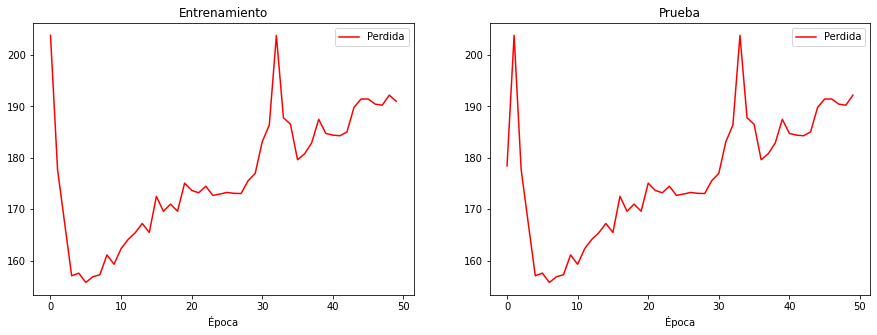

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(loss_hist, 'r', label='Perdida')
axs[0].title.set_text('Entrenamiento')
axs[0].set_xlabel(u'Época')
axs[0].legend()

axs[1].plot(loss_tr_hist, 'r', label='Perdida')
axs[1].title.set_text("Validación")
axs[1].set_xlabel(u'Época')
axs[1].legend()
plt.show()

Grafica de la exactitud en conjunto de validación.

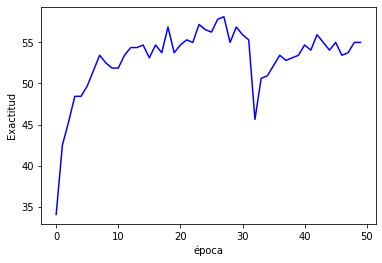

In [50]:
plt.plot(acc_hist, color='b')
plt.xlabel('época')
plt.ylabel('Exactitud')
plt.show()

# 4 Modelo CNN

Implementar una arquitectura CNN con una capa Conv1d.

## 4.1 Definición de la arquitectura.

Se define una modelo de CNN con capa Conv1d, se modifican los parámetros de la capa de convolución para obtener unos parametros totales similares a los que tiene la RNN.

In [41]:
# definición del modelo
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 1 * 285 * 5
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1024, out_channels=285, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2) 
        )                     
        self.flatten = nn.Flatten()        
        self.cls = nn.Linear(self.num_feats, 11)
    
    # metodo para inferencia
    def forward(self, x):  
        # Batch, Seq, Feats
        # [B, S, F] => [B, F, S]      
        x = x.movedim(1, 2)  
        # [B, F, S]       
        x = self.cnn(x)
        # [B, F, S] => [B, S, F]
        x = x.movedim(1, 2)
              
        x = self.flatten(x)        
        x = self.cls(x)
        return x

## 4.2 Inspección de la arquitectura

In [42]:
model = CNN()
print(model)

CNN(
  (cnn): Sequential(
    (0): Conv1d(1024, 285, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=1425, out_features=11, bias=True)
)


In [43]:
summary(model, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 11]                   --
├─Sequential: 1-1                        [1, 285, 5]               --
│    └─Conv1d: 2-1                       [1, 285, 10]              875,805
│    └─ReLU: 2-2                         [1, 285, 10]              --
│    └─MaxPool1d: 2-3                    [1, 285, 5]               --
├─Flatten: 1-2                           [1, 1425]                 --
├─Linear: 1-3                            [1, 11]                   15,686
Total params: 891,491
Trainable params: 891,491
Non-trainable params: 0
Total mult-adds (M): 8.77
Input size (MB): 0.04
Forward/backward pass size (MB): 0.02
Params size (MB): 3.57
Estimated Total Size (MB): 3.63

## 4.3 Prueba de arquitectura

In [44]:
# inferencia con datos sintéticos
x = torch.zeros(1, 10, 1024)
y = model(x)
print(y.shape)

torch.Size([1, 11])


# 5 Entrenamiento

## 5.1 Ciclo de entrenamiento

In [45]:
# creamos un modelo
model = CNN()

# optimizador
opt = optim.SGD(model.parameters(), lr=1e-3)
# historial de pérdida
loss_hist, acc_hist = [],[]
loss_tr_hist = []

# ciclo de entrenamiento
EPOCHS = 50
for epoch in range(EPOCHS):
    
    losses = []
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()
        # guardamos históricos
        losses.append(loss.item() * 100)
    
    loss = np.mean(losses)
    loss_tr_hist.append(loss)

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in take(tst_dl, 10):
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)
        acc_hist.append(acc)
        # modelo en modo de entrenamiento
        model.train()

E 0 loss=239.04 acc=9.69
E 1 loss=237.07 acc=18.44
E 2 loss=235.84 acc=20.31
E 3 loss=234.81 acc=21.56
E 4 loss=233.99 acc=21.56
E 5 loss=233.20 acc=20.62
E 6 loss=232.51 acc=21.88
E 7 loss=231.84 acc=21.56
E 8 loss=231.14 acc=21.25
E 9 loss=230.48 acc=21.25
E10 loss=229.96 acc=20.62
E11 loss=229.37 acc=19.69
E12 loss=228.88 acc=20.62
E13 loss=228.32 acc=19.69
E14 loss=227.72 acc=19.69
E15 loss=227.32 acc=21.25
E16 loss=226.88 acc=21.56
E17 loss=226.32 acc=20.94
E18 loss=225.86 acc=22.19
E19 loss=225.34 acc=21.88
E20 loss=224.81 acc=22.19
E21 loss=224.46 acc=22.50
E22 loss=224.01 acc=22.50
E23 loss=223.50 acc=22.19
E24 loss=223.07 acc=22.81
E25 loss=222.71 acc=23.44
E26 loss=222.30 acc=23.44
E27 loss=222.01 acc=24.38
E28 loss=221.71 acc=23.75
E29 loss=221.29 acc=24.06
E30 loss=220.85 acc=24.38
E31 loss=220.44 acc=24.38
E32 loss=220.29 acc=25.00
E33 loss=219.93 acc=25.31
E34 loss=219.71 acc=26.56
E35 loss=219.28 acc=25.94
E36 loss=218.88 acc=26.56
E37 loss=218.64 acc=27.19
E38 loss=218.

## 5.2 Gráfica de la pérdida

El modelo se ejecuta por 50 épocas, y posteriormente se imprime la perdida durante el entrenamiento y con el conjunto de validación.

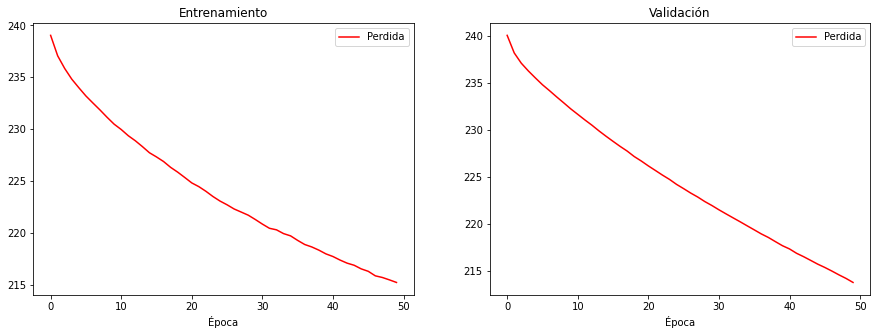

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(loss_hist, 'r', label='Perdida')
axs[0].title.set_text('Entrenamiento')
axs[0].set_xlabel(u'Época')
axs[0].legend()

axs[1].plot(loss_tr_hist, 'r', label='Perdida')
axs[1].title.set_text("Validación")
axs[1].set_xlabel(u'Época')
axs[1].legend()
plt.show()

Grafica de exactitud en conjunto de validación

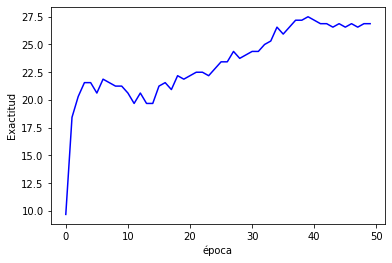

In [47]:
plt.plot(acc_hist, color='b')
plt.xlabel('época')
plt.ylabel('Exactitud')
plt.show()

# 5 Discusión

Para ambos modelos se grafica la perdida durante el entrenamiento y también en validación, estos fueron entrenados durante 50 épocas.  
Existen diferencias significativas, para el caso de la RNN la pérdida baja considerablemente alrededor de la época 7 pero posteriormente esta comienza a subir, en el caso de la exactitud esta sube al punto en que la pérdida llega a su minimo y posteriormente se estanca en un valor promedio de 55. 

Por otro lado en el caso de la CNN la pérdida no presenta un cambio tan brusco esta decrece a un ritmo constante conforme pasan las épocas tanto en el entrenamiento como con el conjunto de validación, al igual que la pérdida la exactitud tiene aumento conforme pasan las épocas, solo alrededor de la época 15 decrece un poco pero de nuevo retoma su aumento, la exactitud mas alta obtenida fue de 27, mas bajo que el modelo de RNN.

Comparando los dos modelos y observando las gráficas, se podría tener una mejor exactitud utilizando el modelo CNN teniendo mas ciclos de entrenamiento, es decir, se requiere de mas tiempo de entrenamiento. Por otro lado se observa que la RNN obtiene mejores resultados con minimos ciclos de entrenamiento. 

Con estos resultados se puede observar la ventaja que tienen los modelos RNN vs los CNN dado que los modelos RNN son mejores cuando se trabaja con datos secuenciales o temporales como los textos o video.

Esta practica fue de bastante ayuda, dado que en mi tesis estoy trabajando con texto y he tenido algunos temas tratando de aplicar un modelo adecuado intentaré aplicar una RNN y veré si obtengo buenos resultados.